In [1]:
from distribution_fit_class import DistributionFit
from portfolio_optimization_class import PortfolioOptimization, optimize_windows
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import glob

In [2]:
copulas = ["clayton_random", "gaussian", "t_student"]
# copulas = ["t_student"]
distributions = ["gauss_dist", "t_dist"]
window_size = 32
taus = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
maximum_weight = 0.3

In [5]:
# number_of_samples = 10000

#if iter == 2 taus CUT else taus = [...]

for iter in range(1, 11):
    file_path = r'data\random_data\1_stocks_per_sector_' + f'{iter}_iter.csv'
    returns_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    tau_aggregation = []

    # if iter == 2:
    #     taus = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
    # else:
    #     taus = [0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]

    for tau_index, tau in enumerate(taus):
        tau_dict = {}
        portfolios = optimize_windows(number_of_quarters=window_size, tau=tau, maximum_weight=maximum_weight, data_path=file_path)
        for copula in copulas:
            absolute_errors_norm = []
            absolute_errors_t = []
            absolute_percentage_errors_norm = []
            absolute_percentage_errors_t = []
            for window in range(0, 64):
                if window % 5 == 0:
                    print(f'Tau: {tau}, Cop: {copula} - {window}')

                returns_window = returns_df.iloc[window : window + window_size - 1]
                distribution_fit = DistributionFit()
                distribution_fit.set_df(returns_window)
                distribution_fit.fit_distribution_all_stocks()

                if iter == 1:
                    simulated_data_path = r'../copulas_outputs/simulated_' + copula + '_11_stocks' + f'_{window}_window.csv'
                else:
                    simulated_data_path = r'../copulas_outputs/simulated_' + copula + '_11_stocks' + f'_{window}_window_{iter}_iter.csv'

                simulated_df = pd.read_csv(simulated_data_path)

                distribution_fit.set_simulated_data_from_df(simulated_df)
                distribution_fit.calculate_returns_from_simulated_quantiles()
                returns_norm = distribution_fit.get_simulated_return_norm()
                returns_t = distribution_fit.get_simulated_return_t_student()

                dist_list = [(returns_t, "t_dist"), (returns_norm, "gauss_dist")]
                for dist_returns, dist_name in dist_list:
                    dist_returns = dist_returns.iloc[:1000]
                    optimizer = PortfolioOptimization()
                    optimizer.set_tau(tau)
                    optimizer.set_maximum_weight(0.3)
                    optimizer.load_simulated_data_from_df(dist_returns)

                    optimizer.build_model()
                    optimizer.solve(verbose=False)
                    evar = optimizer.get_solution_evar()
                    # print(evar)
                    # print(portfolios["EVAR"])
                    theoretical_evar = portfolios.iloc[window]["EVAR"]
                    absolute_error = abs((evar - theoretical_evar))
                    absolute_percentage_error = abs(absolute_error / theoretical_evar) * 100
                    if dist_name == "t_dist":
                        absolute_errors_t.append(absolute_error)
                        absolute_percentage_errors_t.append(absolute_percentage_error)
                    if dist_name == "gauss_dist":
                        absolute_errors_norm.append(absolute_error)
                        absolute_percentage_errors_norm.append(absolute_percentage_error)
            tau_dict[copula+"+t_dist_AE"] = absolute_errors_t
            tau_dict[copula+"+t_dist_APE"] = absolute_percentage_errors_t
            tau_dict[copula+"+gauss_dist_AE"] = absolute_errors_norm
            tau_dict[copula+"+gauss_dist_APE"] = absolute_percentage_errors_norm

        df = pd.DataFrame.from_dict(tau_dict)
        tau_str = str(tau).replace(".", "_")
        # output_path = r"../scores/taus/" + f'tau_{tau_str}/scores_{tau_str}{batch_num}.csv'
        output_path = r"data/errors/" + f'errors_tau_{tau_str}_iter_{iter}.csv'
        df.to_csv(output_path)







Tau: 0.0005, Cop: clayton_random - 0
Tau: 0.0005, Cop: clayton_random - 5
Tau: 0.0005, Cop: clayton_random - 10
Tau: 0.0005, Cop: clayton_random - 15
Tau: 0.0005, Cop: clayton_random - 20
Tau: 0.0005, Cop: clayton_random - 25
Tau: 0.0005, Cop: clayton_random - 30
Tau: 0.0005, Cop: clayton_random - 35
Tau: 0.0005, Cop: clayton_random - 40
Tau: 0.0005, Cop: clayton_random - 45
Tau: 0.0005, Cop: clayton_random - 50
Tau: 0.0005, Cop: clayton_random - 55
Tau: 0.0005, Cop: clayton_random - 60
Tau: 0.0005, Cop: gaussian - 0
Tau: 0.0005, Cop: gaussian - 5
Tau: 0.0005, Cop: gaussian - 10
Tau: 0.0005, Cop: gaussian - 15
Tau: 0.0005, Cop: gaussian - 20
Tau: 0.0005, Cop: gaussian - 25
Tau: 0.0005, Cop: gaussian - 30
Tau: 0.0005, Cop: gaussian - 35
Tau: 0.0005, Cop: gaussian - 40
Tau: 0.0005, Cop: gaussian - 45
Tau: 0.0005, Cop: gaussian - 50
Tau: 0.0005, Cop: gaussian - 55
Tau: 0.0005, Cop: gaussian - 60
Tau: 0.0005, Cop: t_student - 0
Tau: 0.0005, Cop: t_student - 5
Tau: 0.0005, Cop: t_student - 

In [46]:
number_of_samples = 10000


for iter in range(2, 11):
    file_path = r'data\random_data\1_stocks_per_sector_' + f'{iter}_iter.csv'
    returns_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
    tau_aggregation = []

    for tau_index, tau in enumerate(taus):
        tau_dict = {}
        portfolios = optimize_windows(number_of_quarters=window_size, tau=tau, maximum_weight=maximum_weight, data_path=file_path)

        absolute_errors_norm = []
        absolute_errors_t = []
        absolute_percentage_errors_norm = []
        absolute_percentage_errors_t = []
        for window in range(0, 64):
            if window % 5 == 0:
                print(f'Iter: {iter}, Tau: {tau}, - {window}')

            returns_window = returns_df.iloc[window : window + window_size - 1]
            distribution_fit = DistributionFit()
            distribution_fit.set_df(returns_window)

            distribution_fit.fit_multivariate_distributions(4)

            distribution_fit.generate_multivariate_normal_samples(1000)
            distribution_fit.generate_multivariate_t_samples(1000)

            samples_normal = distribution_fit.get_generated_multivariated_normal_samples()
            samples_t = distribution_fit.get_generated_multivariated_t_samples()
            # print(samples_normal)

            distributions_samples = [
                (samples_normal, "gauss_dist"),
                (samples_t, "t_dist")
            ]


            for dist_returns, dist_name in distributions_samples:
                dist_returns = dist_returns.iloc[:1000]
                optimizer = PortfolioOptimization()
                optimizer.set_tau(tau)
                optimizer.set_maximum_weight(0.3)
                optimizer.load_simulated_data_from_df(dist_returns)

                optimizer.build_model()
                optimizer.solve(verbose=False)
                evar = optimizer.get_solution_evar()
                # print(evar)
                # print(portfolios["EVAR"])
                theoretical_evar = portfolios.iloc[window]["EVAR"]
                absolute_error = abs((evar - theoretical_evar))
                absolute_percentage_error = abs(absolute_error / theoretical_evar) * 100
                if dist_name == "t_dist":
                    absolute_errors_t.append(absolute_error)
                    absolute_percentage_errors_t.append(absolute_percentage_error)
                if dist_name == "gauss_dist":
                    absolute_errors_norm.append(absolute_error)
                    absolute_percentage_errors_norm.append(absolute_percentage_error)
        tau_dict["multivariate_t_dist_AE"] = absolute_errors_t
        tau_dict["multivariate_t_dist_APE"] = absolute_percentage_errors_t
        tau_dict["multivariate_gauss_dist_AE"] = absolute_errors_norm
        tau_dict["multivariate_gauss_dist_APE"] = absolute_percentage_errors_norm

        df = pd.DataFrame.from_dict(tau_dict)
        tau_str = str(tau).replace(".", "_")
        # output_path = r"../scores/taus/" + f'tau_{tau_str}/scores_{tau_str}{batch_num}.csv'
        output_path = r"data/errors/" + f'multivariate_errors_tau_{tau_str}_iter_{iter}.csv'
        df.to_csv(output_path)


Iter: 2, Tau: 0.0005, - 0
Iter: 2, Tau: 0.0005, - 5
Iter: 2, Tau: 0.0005, - 10
Iter: 2, Tau: 0.0005, - 15
Iter: 2, Tau: 0.0005, - 20
Iter: 2, Tau: 0.0005, - 25
Iter: 2, Tau: 0.0005, - 30
Iter: 2, Tau: 0.0005, - 35
Iter: 2, Tau: 0.0005, - 40
Iter: 2, Tau: 0.0005, - 45
Iter: 2, Tau: 0.0005, - 50
Iter: 2, Tau: 0.0005, - 55
Iter: 2, Tau: 0.0005, - 60
Iter: 2, Tau: 0.001, - 0
Iter: 2, Tau: 0.001, - 5
Iter: 2, Tau: 0.001, - 10
Iter: 2, Tau: 0.001, - 15
Iter: 2, Tau: 0.001, - 20
Iter: 2, Tau: 0.001, - 25
Iter: 2, Tau: 0.001, - 30
Iter: 2, Tau: 0.001, - 35
Iter: 2, Tau: 0.001, - 40
Iter: 2, Tau: 0.001, - 45
Iter: 2, Tau: 0.001, - 50
Iter: 2, Tau: 0.001, - 55
Iter: 2, Tau: 0.001, - 60
Iter: 2, Tau: 0.002, - 0
Iter: 2, Tau: 0.002, - 5
Iter: 2, Tau: 0.002, - 10
Iter: 2, Tau: 0.002, - 15
Iter: 2, Tau: 0.002, - 20
Iter: 2, Tau: 0.002, - 25
Iter: 2, Tau: 0.002, - 30
Iter: 2, Tau: 0.002, - 35
Iter: 2, Tau: 0.002, - 40
Iter: 2, Tau: 0.002, - 45
Iter: 2, Tau: 0.002, - 50
Iter: 2, Tau: 0.002, - 55
Iter:

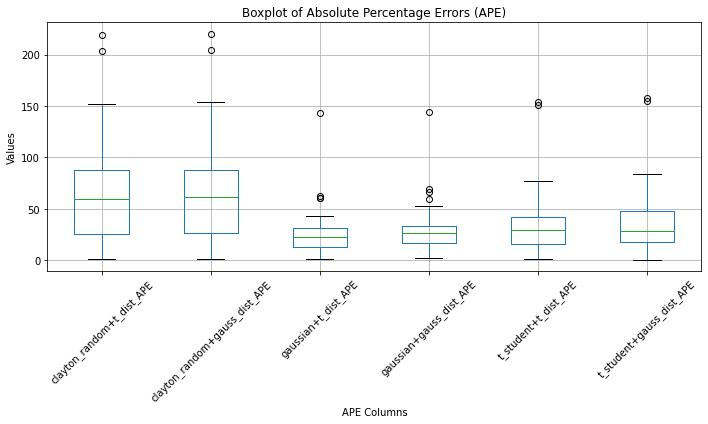

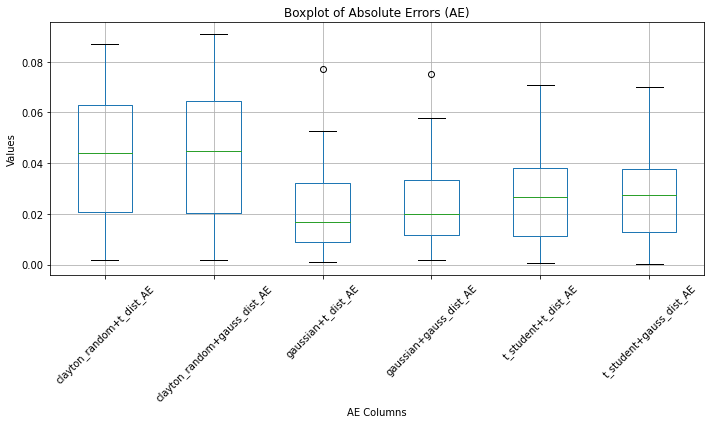

In [6]:
df = pd.read_csv("data/errors/errors_tau_0_001_iter_2.csv", index_col=0)
ape_columns = [col for col in df.columns if 'APE' in col]


plt.figure(figsize=(10, 6))
df[ape_columns].boxplot()
plt.title('Boxplot of Absolute Percentage Errors (APE)')
plt.xlabel('APE Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ae_columns = [col for col in df.columns if 'AE' in col]

plt.figure(figsize=(10, 6))
df[ae_columns].boxplot()
plt.title('Boxplot of Absolute Errors (AE)')
plt.xlabel('AE Columns')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
errors_folder = "data/errors/"


error_files = glob.glob(os.path.join(errors_folder, "errors_tau_*.csv"))

aggregated_data = {}

for file in error_files:
    tau_str = file.split("_tau_")[1].split("_iter")[0].replace("_", ".")
    tau_value = float(tau_str)
    df = pd.read_csv(file, index_col=0)
    means = df.mean(axis=0)
    if tau_value not in aggregated_data:
        aggregated_data[tau_value] = []
    aggregated_data[tau_value].append(means)


final_results = {}

for tau_value, mean_values_list in aggregated_data.items():
    combined_means = pd.concat(mean_values_list, axis=1).mean(axis=1)

    final_results[tau_value] = combined_means

final_df = pd.DataFrame(final_results).T
final_df.sort_index(inplace=True)
final_df.index.name = "Tau"



In [6]:
errors_folder = "data/errors/"


error_files = glob.glob(os.path.join(errors_folder, "multivariate_errors_tau_*.csv"))

aggregated_data = {}

for file in error_files:
    tau_str = file.split("_tau_")[1].split("_iter")[0].replace("_", ".")
    tau_value = float(tau_str)
    df = pd.read_csv(file, index_col=0)
    means = df.mean(axis=0)
    if tau_value not in aggregated_data:
        aggregated_data[tau_value] = []
    aggregated_data[tau_value].append(means)


final_results = {}

for tau_value, mean_values_list in aggregated_data.items():
    combined_means = pd.concat(mean_values_list, axis=1).mean(axis=1)

    final_results[tau_value] = combined_means

multivariate_final_df = pd.DataFrame(final_results).T
multivariate_final_df.sort_index(inplace=True)
multivariate_final_df.index.name = "Tau"

In [7]:
merged_df = pd.merge(final_df, multivariate_final_df, left_index=True, right_index=True)
merged_df

,clayton_random+t_dist_AE,clayton_random+t_dist_APE,clayton_random+gauss_dist_AE,clayton_random+gauss_dist_APE,gaussian+t_dist_AE,gaussian+t_dist_APE,gaussian+gauss_dist_AE,gaussian+gauss_dist_APE,t_student+t_dist_AE,t_student+t_dist_APE,t_student+gauss_dist_AE,t_student+gauss_dist_APE,multivariate_t_dist_AE,multivariate_t_dist_APE,multivariate_gauss_dist_AE,multivariate_gauss_dist_APE
Tau,,,,,,,,,,,,,,,,
0.0005,0.049226,87.360992,0.050385,89.295193,0.023537,40.741023,0.026399,45.604314,0.030647,53.546132,0.032697,56.993212,0.184340,304.171226,0.039555,70.660200
0.0010,0.042527,76.710143,0.043863,78.972824,0.019617,33.740814,0.022178,38.233537,0.024880,43.438090,0.026943,47.014725,0.154999,264.005746,0.032710,59.453197
0.0020,0.035187,65.507086,0.036741,68.209644,0.016107,27.277435,0.018039,31.050533,0.019351,33.639600,0.021128,36.947562,0.127733,225.780955,0.025858,48.553705
0.0050,0.025120,51.501220,0.026959,54.897485,0.013301,22.071378,0.013707,23.743666,0.014353,24.876106,0.015142,26.980516,0.088016,171.552519,0.017668,35.758928
0.0100,0.018098,45.480328,0.019944,49.579380,0.012230,22.122104,0.011444,22.020120,0.012841,23.836661,0.012355,24.028073,0.064956,152.244050,0.012820,31.523865
0.0200,0.012279,59.872088,0.013923,62.676757,0.011254,35.720758,0.009595,37.364726,0.012391,33.118078,0.010689,34.573976,0.045232,158.974767,0.008642,27.174973
0.0500,0.007304,55.390701,0.008335,60.812685,0.009339,41.904589,0.007089,37.200551,0.011496,53.790291,0.008881,45.424415,0.027284,180.484572,0.005254,34.705530
0.1000,0.005288,129.303322,0.005914,140.778670,0.007695,169.319419,0.005769,138.158822,0.010021,226.626108,0.007496,189.122012,0.017959,502.112613,0.004384,112.793642
0.1500,0.004854,207.695975,0.005195,257.143889,0.006861,180.081326,0.005412,116.726702,0.008885,194.435137,0.006822,153.703351,0.014136,540.762391,0.004173,117.572718


In [ ]:
# final_df = final_df.iloc[:7]
# final_df

,clayton_random+t_dist_AE,clayton_random+t_dist_APE,clayton_random+gauss_dist_AE,clayton_random+gauss_dist_APE,gaussian+t_dist_AE,gaussian+t_dist_APE,gaussian+gauss_dist_AE,gaussian+gauss_dist_APE,t_student+t_dist_AE,t_student+t_dist_APE,t_student+gauss_dist_AE,t_student+gauss_dist_APE
Tau,,,,,,,,,,,,
0.0005,0.049226,87.360992,0.050385,89.295193,0.023537,40.741023,0.026399,45.604314,0.030647,53.546132,0.032697,56.993212
0.0010,0.042527,76.710143,0.043863,78.972824,0.019617,33.740814,0.022178,38.233537,0.024880,43.438090,0.026943,47.014725
0.0020,0.035187,65.507086,0.036741,68.209644,0.016107,27.277435,0.018039,31.050533,0.019351,33.639600,0.021128,36.947562
0.0050,0.025120,51.501220,0.026959,54.897485,0.013301,22.071378,0.013707,23.743666,0.014353,24.876106,0.015142,26.980516
0.0100,0.018098,45.480328,0.019944,49.579380,0.012230,22.122104,0.011444,22.020120,0.012841,23.836661,0.012355,24.028073
0.0200,0.012279,59.872088,0.013923,62.676757,0.011254,35.720758,0.009595,37.364726,0.012391,33.118078,0.010689,34.573976
0.0500,0.007304,55.390701,0.008335,60.812685,0.009339,41.904589,0.007089,37.200551,0.011496,53.790291,0.008881,45.424415


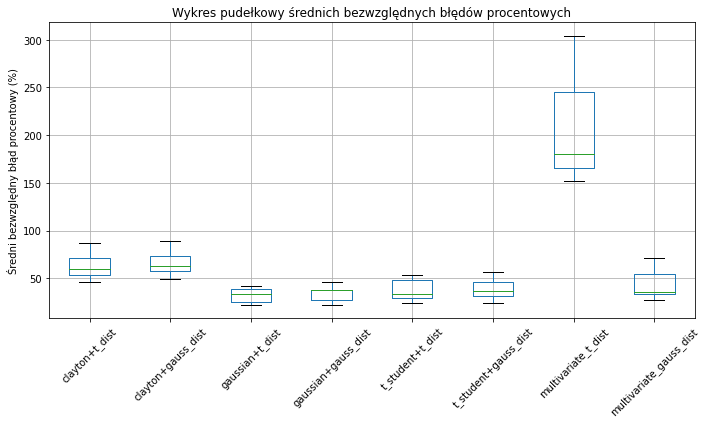

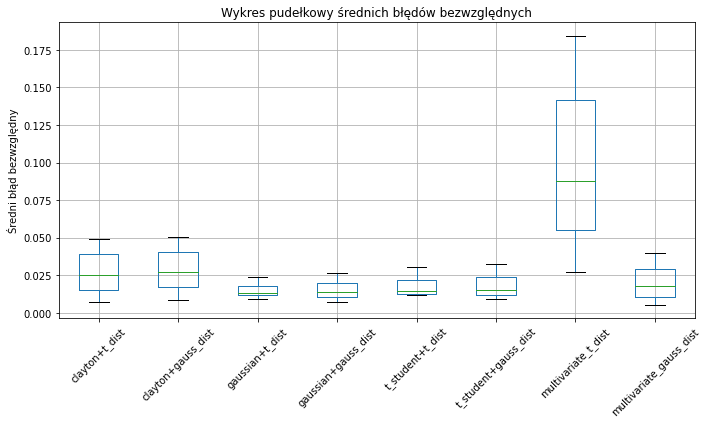

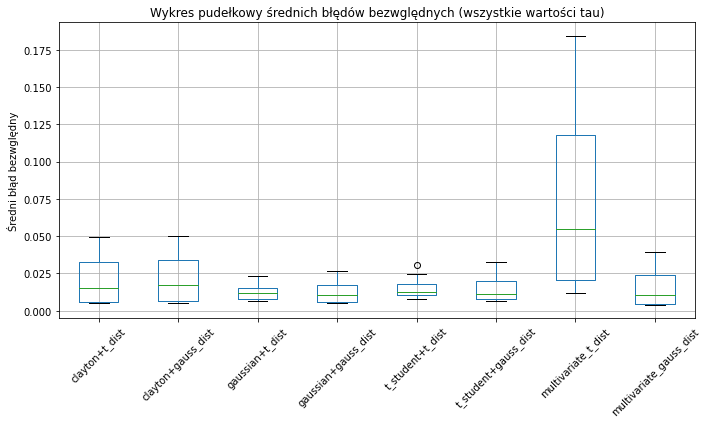

In [11]:
columns_to_rename = [col for col in merged_df.columns if col.startswith('clayton_random+')]
renamed_columns = {col: col.replace('clayton_random+', 'clayton+') for col in columns_to_rename}

# Apply the renaming to the DataFrame
merged_df = merged_df.rename(columns=renamed_columns)

merged_df_cut = merged_df.iloc[:7]


ape_columns = [col for col in merged_df_cut.columns if 'APE' in col]
# ape_columns.remove("multivariate_t_dist_APE")
clean_ape_columns = [col.replace('_APE', '').strip() for col in ape_columns]

plt.figure(figsize=(10, 6))
merged_df_cut[ape_columns].boxplot()
plt.title('Wykres pudełkowy średnich bezwzględnych błędów procentowych')
plt.ylabel('Średni bezwzględny błąd procentowy (%)')
plt.xticks(ticks=range(1, len(clean_ape_columns) + 1), labels=clean_ape_columns, rotation=45)
plt.tight_layout()
plt.show()


ae_columns = [col for col in merged_df_cut.columns if 'AE' in col]
# ae_columns.remove("multivariate_t_dist_AE")
clean_ae_columns = [col.replace('_AE', '').strip() for col in ae_columns]

plt.figure(figsize=(10, 6))
merged_df_cut[ae_columns].boxplot()
plt.title('Wykres pudełkowy średnich błędów bezwzględnych')
plt.ylabel('Średni błąd bezwzględny')
plt.xticks(ticks=range(1, len(clean_ae_columns) + 1), labels=clean_ae_columns, rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
merged_df[ae_columns].boxplot()
plt.title('Wykres pudełkowy średnich błędów bezwględnych (wszystkie wartości tau)')
plt.ylabel('Średni błąd bezwględny')
plt.xticks(ticks=range(1, len(clean_ae_columns) + 1), labels=clean_ae_columns, rotation=45)
plt.tight_layout()
plt.show()



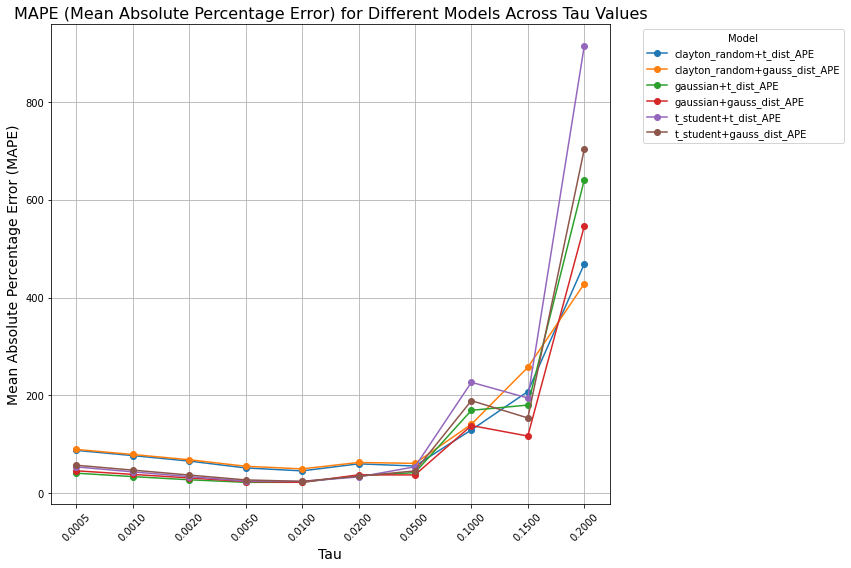

In [8]:
ape_columns = [col for col in final_df.columns if "APE" in col]
df_ape = final_df[ape_columns]

# Plot
plt.figure(figsize=(12, 8))
x_axis = [100*i for i in range(10)]

for col in df_ape.columns:
    plt.plot(x_axis, df_ape[col], marker='o', label=col)

plt.xlabel("Tau", fontsize=14)
plt.ylabel("Mean Absolute Percentage Error (MAPE)", fontsize=14)
plt.title("MAPE (Mean Absolute Percentage Error) for Different Models Across Tau Values", fontsize=16)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(x_axis, labels=[f"{tau:.4f}" for tau in df_ape.index], rotation=45)
plt.grid(visible=True)
plt.tight_layout()

plt.show()

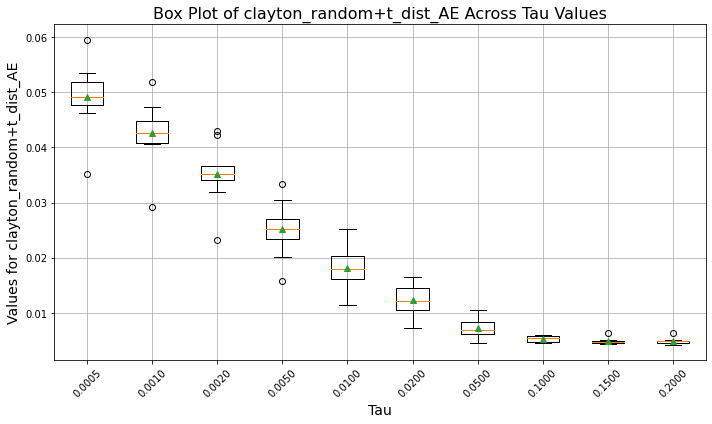

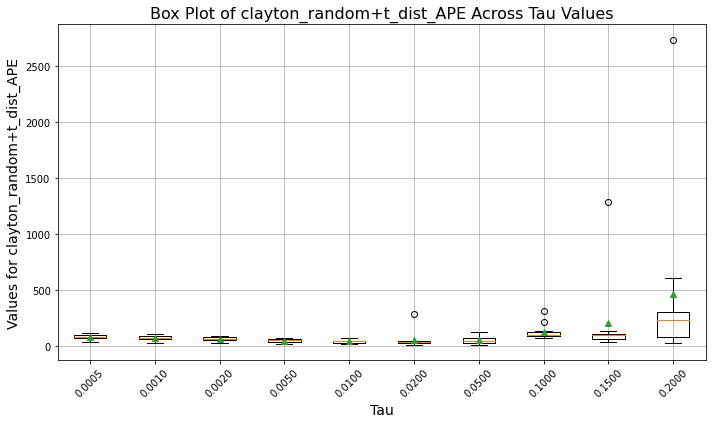

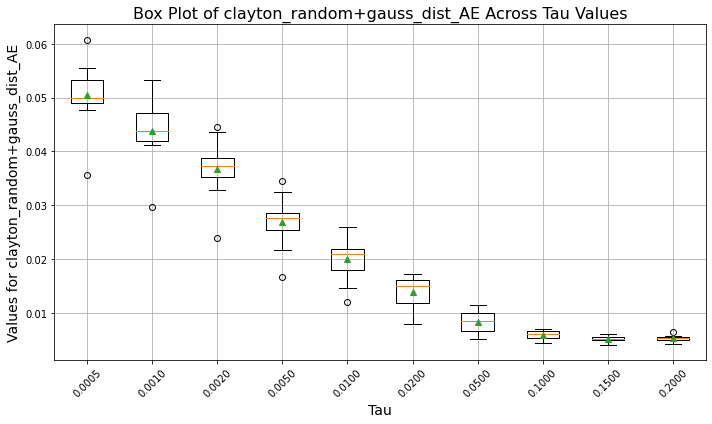

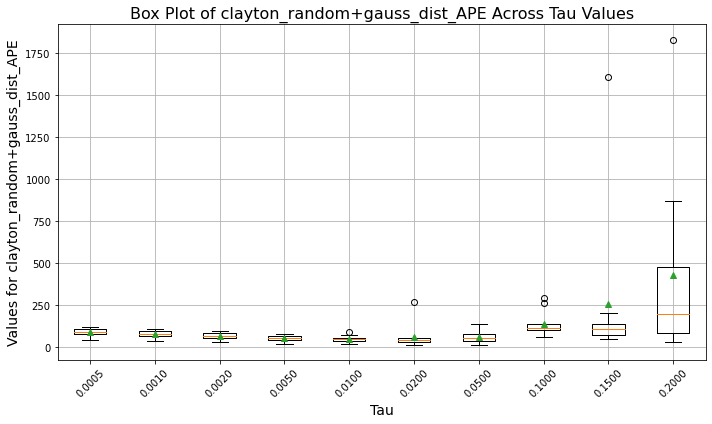

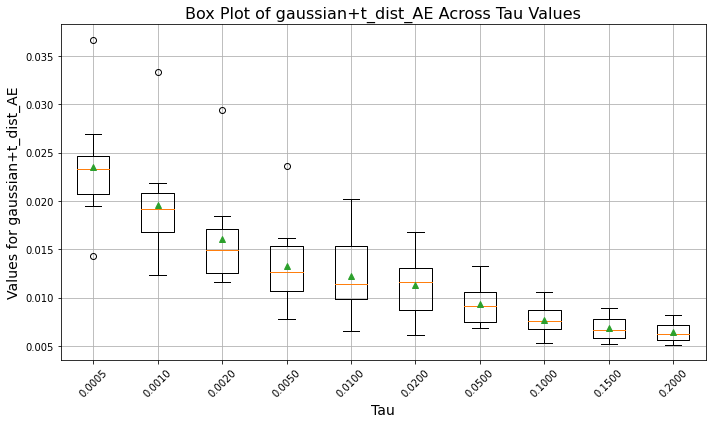

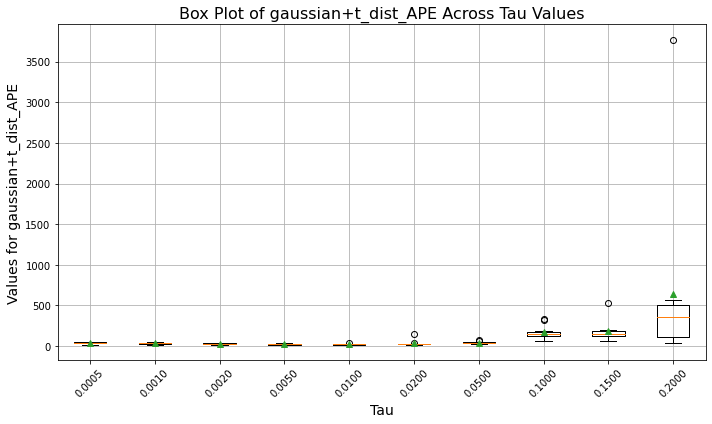

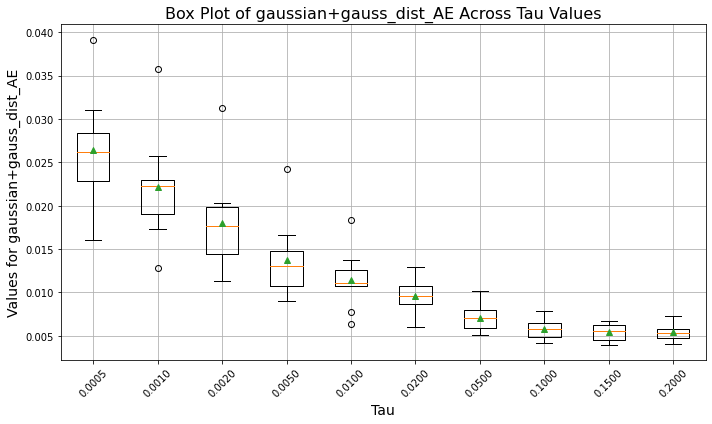

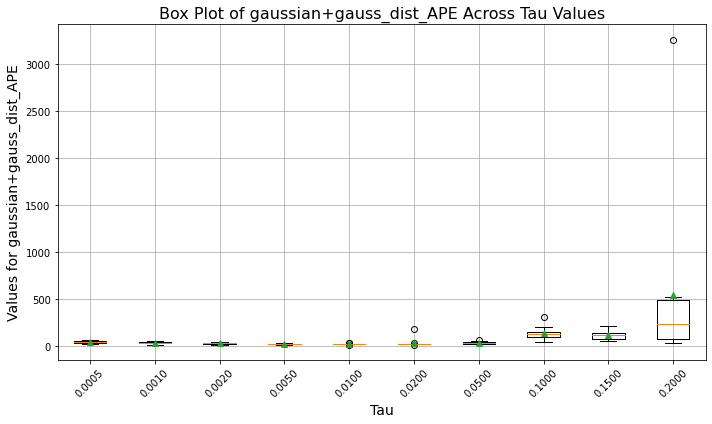

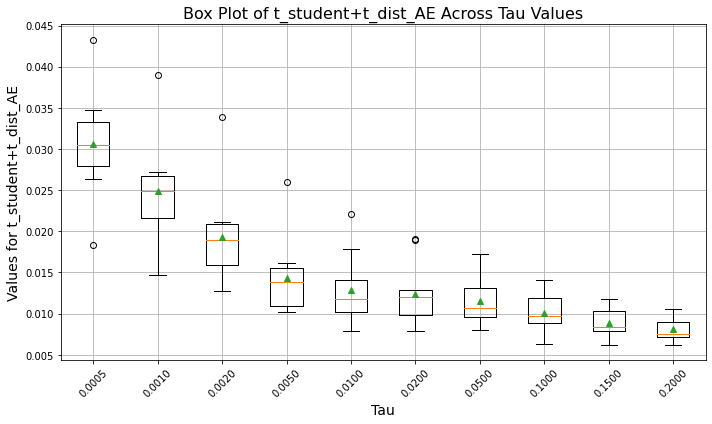

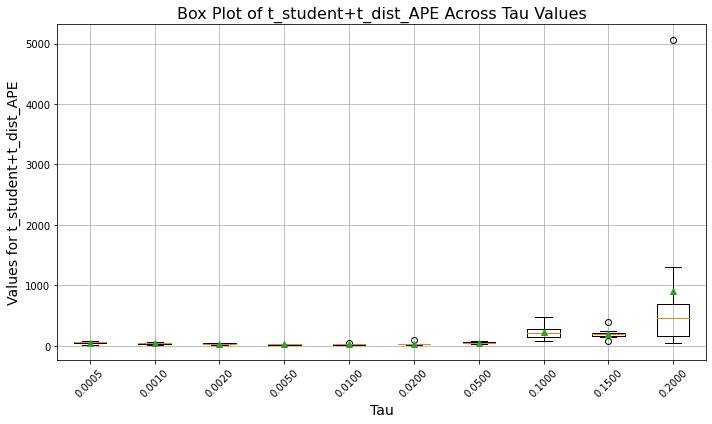

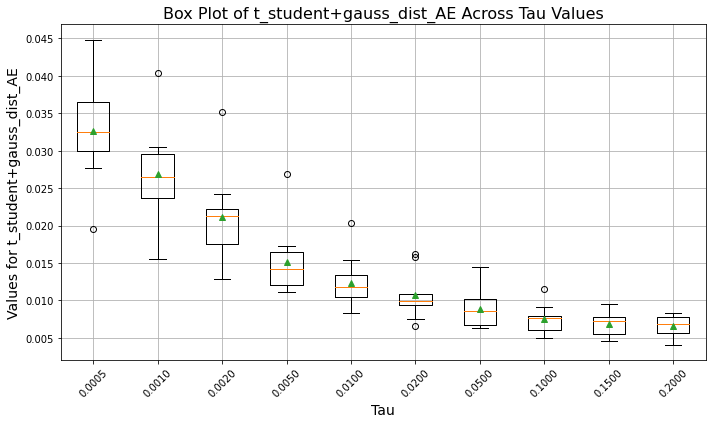

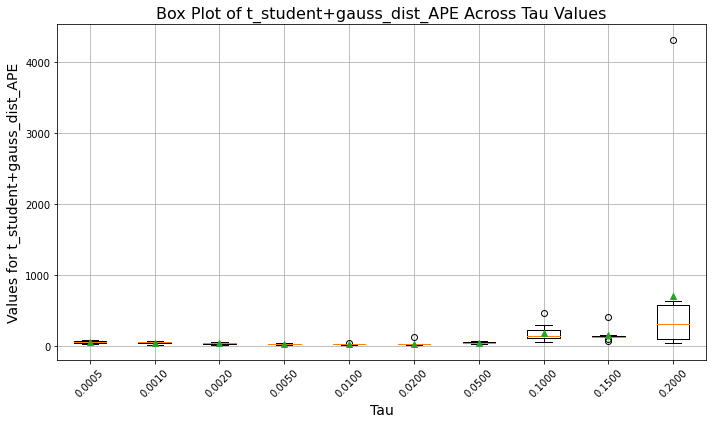

In [ ]:
models = aggregated_data[list(aggregated_data.keys())[0]][0].index


for model in models:
    model_data = []
    tau_labels = []

    for tau, portfolios in aggregated_data.items():
        model_values = [portfolio[model] for portfolio in portfolios]
        model_data.append(model_values)
        tau_labels.append(tau)



    sorted_indices = sorted(range(len(tau_labels)), key=lambda k: tau_labels[k])
    tau_labels = [tau_labels[i] for i in sorted_indices]
    model_data = [model_data[i] for i in sorted_indices]

    tau_labels = tau_labels[:-2]
    model_data = model_data[:-2]

    plt.figure(figsize=(10, 6))
    plt.boxplot(model_data, labels=[f"{tau:.4f}" for tau in tau_labels], showmeans=True)

    plt.title(f"Box Plot of {model} Across Tau Values", fontsize=16)
    plt.xlabel("Tau", fontsize=14)
    plt.ylabel(f"Values for {model}", fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(visible=True)

    plt.tight_layout()
    plt.show()